# Exercise 5 - Variational quantum Eigensolver
---

#### 1.Driver  
The interfaces to the classical chemistry codes that are available in Qiskit are called drivers. We have for example, `PSI4Driver`, `PyQuanteDriver`, `PySCFDriver` are available.  

By running a driver (Hartree-Fock calculation for a given basis set and molecular geometry), in the cell below, we obtain all the necessary information about our molecule to apply then a quantum algorithm.

In [1]:
from qiskit_nature.drivers import PySCFDriver

molecule = 'Li 0.0 0.0 0.0; H 0.0 0.0 1.5474'
driver = PySCFDriver(atom=molecule)
qmolecule = driver.run()

We can look at the attributes of `qmolecule`:

In [2]:
# We can calculate the number of electrons
n_electrons = qmolecule.num_alpha + qmolecule.num_beta
print(n_electrons)

# Number of molecular orbitals
n_molecular_orbitals = qmolecule.num_molecular_orbitals
print(n_molecular_orbitals)

# Number of spin orbitals = 2 * number of molecular orbitals
n_spin_orbitals = 2*qmolecule.num_molecular_orbitals
print(n_spin_orbitals)

# Number of qubits needed to simulate the given LiH molecule with JordanWigner Mapping is equal to number of spin orbitals
num_qubits = 2*qmolecule.num_molecular_orbitals
print(num_qubits)

# Nuclear repulsion energy
nuc_rep_energy = qmolecule.nuclear_repulsion_energy
print(nuc_rep_energy)

4
6
12
12
1.0259348796432726


#### 2. Electronic structure problem  
You can then create an `ElectronicStructureProblem` that can produce the list of fermionic operators before mapping them to qubits (Pauli Strings).  
We also import the `FreezeCoreTransformer` transformer which freezes the core orbitals of the molecule (in our case, the core orbital index is `0`.  

As visible in the following cell, we have specified another argument named `remove_orbitals` with value `[3,4]`. This is part of the transformation we perform to simplify our problem , and reduce the number of qubits required to handle the problem. The `remove_orbitals` argument removes additional orbitals from consideration in order to simplify the problem. Here we remove the additional (unoccupied) orbitals of high energy which have indices 3,4 in the list of orbitals.  

This removing of orbitals and freezing of core orbitals is in accordance with the Born-Oppenheimer approximation, which separates the electronic motion and nuclear motion in a molecule. Under 
the Born-Oppenheimer approximation, the lowest energy (core) orbitals, by virtue of interacting minimally with the system, and the highest energy (*and unoccupied*) orbitals can be removed from consideration. They do not contribute signifcantly to calculation of ground state energy.  
The remaining orbitals are known as "active-space" orbitals.

In [3]:
from qiskit_nature.problems.second_quantization.electronic import ElectronicStructureProblem
from qiskit_nature.transformers import FreezeCoreTransformer

problem = ElectronicStructureProblem(driver, q_molecule_transformers=[FreezeCoreTransformer(freeze_core = True,
                                                                                            remove_orbitals = [3,4])])

# Generate the second-quantized operators
second_q_ops = problem.second_q_ops()

#Hamiltonian
main_op = second_q_ops[0]

#### 3. Qubit Converter  

Allows to define the mapping that you will use in the simulation. The mapping I used is the `ParityMapper`, since it further allows the reduction of 2 qubits and simplifies the problem.

In [4]:
from qiskit_nature.mappers.second_quantization import ParityMapper
from qiskit_nature.converters.second_quantization.qubit_converter import QubitConverter

# Set up the mapper and qubit converter
mapper = ParityMapper()

converter = QubitConverter(mapper = mapper, two_qubit_reduction=True)

# Fermionic operators (creation and annihilation) are mapped to qubit operators
num_particles = (problem.molecule_data_transformed.num_alpha, problem.molecule_data_transformed.num_beta)

qubit_op = converter.convert(main_op, num_particles=num_particles)

#### 4. Initial State  
A good initial state in chemistry is the Hartree-Fock (HF) state (i.e. $|0101\rangle$). We can initialize it as follows:

In [5]:
from qiskit_nature.circuit.library import HartreeFock

num_particles = (problem.molecule_data_transformed.num_alpha, problem.molecule_data_transformed.num_beta)

num_spin_orbitals = 2*problem.molecule_data_transformed.num_molecular_orbitals
init_state = HartreeFock(num_spin_orbitals, num_particles, converter)
print(init_state)

     ┌───┐
q_0: ┤ X ├
     ├───┤
q_1: ┤ X ├
     └───┘
q_2: ─────
          
q_3: ─────
          


#### 5. Ansatz
One of the most important choices is the qauntum circuit that you choose to approximate your ground state. Here I have used the TwoLocal ansatz provided by qiskit (circuit drawing in later cells).

OrderedDict([('ry', 8), ('rz', 8), ('cx', 3), ('x', 2)])


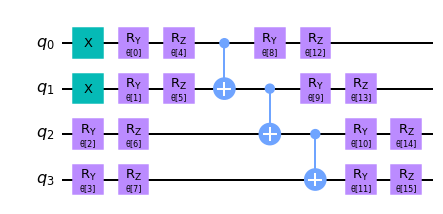

In [6]:
from qiskit.circuit.library import TwoLocal

# Single qubit rotations that are placed on all qubtis with independent parameters
rotation_blocks = ['ry','rz']

# entangling gates
entanglement_blocks = 'cx'

# How the qubits are entangled (possible values: 'full', 'linear', 'circular', 'sca')
entanglement = 'linear'

# Repetitions of rotation_blocks + entanglement_blocks with independent parameters
repetitions = 1

# Skip the final rotation_blocks layer
skip_final_rotation_layer = False

ansatz = TwoLocal(qubit_op.num_qubits, rotation_blocks=rotation_blocks, 
                  entanglement_blocks=entanglement_blocks, reps = repetitions, entanglement=entanglement,
                  skip_final_rotation_layer=skip_final_rotation_layer)

# Add the initial state
ansatz.compose(init_state, front=True, inplace = True)

print(ansatz.count_ops())
ansatz.draw('mpl')

#### 6. Backend
This is where you specify the simulator or device where you want to run your algorithm. We will focus on the `statevector_simulator` in this challenge.

In [7]:
from qiskit import Aer
backend = Aer.get_backend('statevector_simulator')

#### 7. Optimizer
The optimizier guides the evolution of the parameters of the ansarz so it is very important to investigate the energy convergence as it would define the number of measurements that have to be performed on the QPU. A clever choice might reduce drastically the number of needed energy evaluations.

In [8]:
from qiskit.algorithms.optimizers import SLSQP

optimizer = SLSQP(maxiter=500)

#### 8. Exact Eigensolver

For learning purposes, we can solve the problem exactly with the exact diagonalization of the Hamiltonian matrix so we know where to aim with VQE. Of course, the dimensions of this matrix scale exponentially in the number of molecular orbitals so you can try doing this for a larger molecule of your choice and see how slow this becomes. For very large systems you would run out of memory trying to store their wavefunctions.

In [9]:
from qiskit_nature.algorithms.ground_state_solvers.minimum_eigensolver_factories import NumPyMinimumEigensolverFactory
from qiskit_nature.algorithms.ground_state_solvers import GroundStateEigensolver
import numpy as np

def exact_diagonalizer(problem, converter):
    solver = NumPyMinimumEigensolverFactory()
    calc = GroundStateEigensolver(converter, solver)
    result = calc.solve(problem)
    return result

result_exact = exact_diagonalizer(problem, converter)
exact_energy = np.real(result_exact.eigenenergies[0])
print("Exact electronic energy", exact_energy)
print(result_exact)

Exact electronic energy -1.0887060157347397
=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -8.907396311316
  - computed part:      -1.088706015735
  - FreezeCoreTransformer extracted energy part: -7.818690295581
~ Nuclear repulsion energy (Hartree): 1.025934879643
> Total ground state energy (Hartree): -7.881461431673
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  2.92416221]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  4.76300889]
    - computed part:      [0.0  0.0  4.76695575]
    - FreezeCoreTransformer extracted energy part: [0.0  0.0  -0.00394686]
  > Dipole moment (a.u.): [0.0  0.0  -1.83884668]  Total: 1.83884668
                 (debye): [0.0  0.0  -4.67388163]  Total: 4.67388163
 


#### 9. VQE and initial parameters for the ansatz
Now we can import the VQE class and run the algorithm

In [10]:
from qiskit.algorithms import VQE
from IPython.display import display, clear_output

# Print and save the data in lists
def callback(eval_count, parameters, mean, std):
    # Overwrites the same line when printing
    display("Evaluation: {}, Energy: {}, Std: {}".format(eval_count, mean, std))
    clear_output(wait=True)
    counts.append(eval_count)
    values.append(mean)
    params.append(parameters)
    deviation.append(std)
    
counts = []
values = []
params = []
deviation = []

# Set initial parameters of the ansatz
# We choose a fixed samll displacement

try:
    initial_point = [0.01] * len(ansatz.ordered_parameters)
except:
    initial_point = [0.01] * ansatz.num_parameters


algorithm = VQE(ansatz, 
                optimizer = optimizer,
                quantum_instance=backend,
                callback = callback, 
                initial_point = initial_point)

result = algorithm.compute_minimum_eigenvalue(qubit_op)
print(result)

{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 832,
    'eigenstate': array([ 1.39107158e-03+1.62881639e-04j, -4.80388019e-03-1.46986147e-04j,
        2.62445688e-02+8.47612932e-04j, -9.91330312e-01+1.36852259e-02j,
       -5.37453169e-02-3.77342450e-03j, -3.69333133e-04-8.90827266e-05j,
        8.79291486e-04-4.46330708e-06j, -2.32772516e-02+1.49221902e-03j,
       -2.67379761e-03-7.05398203e-05j, -1.12001830e-05-8.31915326e-06j,
        3.67134979e-06+2.34852365e-05j,  3.09802908e-04-9.10780549e-04j,
        1.13572091e-01-2.69541082e-03j,  5.55565625e-04+1.40856912e-04j,
       -5.49422918e-04+3.83240302e-05j, -2.95627080e-05-1.93824609e-05j]),
    'eigenvalue': -1.086347201459816,
    'optimal_parameters': {   ParameterVectorElement(θ[0]): 0.25215446219785737,
                              ParameterVectorElement(θ[1]): -0.005427316364644847,
                              ParameterVectorElement(θ[2]): -3.1415186174279306,
                              ParameterVect

#### 9. Scoring Function

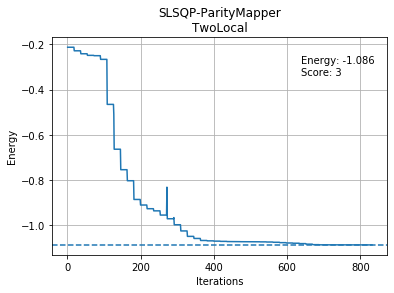

In [11]:
# Store results in a dictionary
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import Unroller

# Unroller transpile your circuit into CNOTs and U gates
pass_ = Unroller(['u', 'cx'])
pm = PassManager(pass_)
ansatz_tp = pm.run(ansatz)
cnots = ansatz_tp.count_ops()['cx']
score = cnots

accuracy_threshold = 4.0 # in mHa
energy = result.optimal_value


result_dict = {
    'optimizer': optimizer.__class__.__name__ ,
    'mapping': converter.mapper.__class__.__name__,
    'ansatz': ansatz.__class__.__name__,
    'rotation blocks': None,
    'entanglement_blocks': None,
    'entanglement': None,
    'repetitions': None,
    'skip_final_rotation_layer': None,
    'energy (Ha)': energy,
    'error (mHa)': (energy-exact_energy)*1000,
    'pass': (energy-exact_energy)*1000 <= accuracy_threshold,
    '# of parameters': len(result.optimal_point),
    'final parameters': result.optimal_point,
    '# of evaluations': result.optimizer_evals,
    'optimizer time': result.optimizer_time,
    '# of qubits': int(qubit_op.num_qubits),
    '# of CNOTs': cnots,
    'score': score
}

# Plot the results
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1)
ax.set_xlabel('Iterations')
ax.set_ylabel('Energy')
ax.grid()
fig.text(0.7, 0.75, f'Energy: {result.optimal_value:.3f}\nScore: {score:.0f}')
plt.title(f"{result_dict['optimizer']}-{result_dict['mapping']}\n{result_dict['ansatz']}")
ax.plot(counts, values)
ax.axhline(exact_energy, linestyle='--')
fig_title = f"\
{result_dict['optimizer']}-\
{result_dict['mapping']}-\
{result_dict['ansatz']}-\
Energy({result_dict['energy (Ha)']:.3f})-\
Score({result_dict['score']:.0f})\
.png"
fig.savefig(fig_title, dpi=300)

---

In [12]:
print("SCORE: {}".format(result_dict['score']))
print("ERROR: {} mHa".format(result_dict['error (mHa)']))
print("NUMBER OF PARAMETERS: {}".format(result_dict['# of parameters']))

SCORE: 3
ERROR: 2.358814274923793 mHa
NUMBER OF PARAMETERS: 16
